<a href="https://colab.research.google.com/github/JosephThompson607/dir_vae/blob/main/sepsis_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
from __future__ import print_function
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


In [36]:
import kagglehub
#Reading df
# Kaggle toy set
housing_df = pd.read_csv("/content/Housing.csv")
housing_df["expensive"] = housing_df["price"] > 1000000 #for evaluation (Sepsis standin)
patients = housing_df.drop(columns=["expensive","price"] )


#actual df
# patients = pd.read_csv("/content/unique_patient_dem.csv")
# print(patients.columns)
# patients.drop(columns=['subject_id'], inplace=True)

In this section we prepare the data for training

In [37]:
#TODO: Read this from the cloud

numeric_cols = patients.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = patients.select_dtypes(exclude=[np.number]).columns.tolist()
# Reorder DataFrame
patients = patients[numeric_cols + categorical_cols]
#1 hot encoding
df_encoded = pd.get_dummies(patients, columns=categorical_cols)
print(df_encoded.columns)
#If cuda is available, device is cuda, otherwise cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Scaling numeric columns
scaler = StandardScaler()
df_encoded[numeric_cols] = scaler.fit_transform(df_encoded[numeric_cols])
features = df_encoded.astype('float32').values


# Get indices for slicing
num_indices = list(range(len(numeric_cols)))
n_numeric = len(numeric_cols)
cat_indices = list(range(len(numeric_cols), len(features)))
tensor = torch.tensor(features, dtype=torch.float32)

X_train, X_test = train_test_split(tensor, test_size=0.2, random_state=42)

train_dataset = TensorDataset(X_train)
test_dataset = TensorDataset(X_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
input_size = X_train[0].shape[0] #input size is the number of features going into the network
print(input_size)

Index(['area', 'bedrooms', 'bathrooms', 'stories', 'parking', 'mainroad_no',
       'mainroad_yes', 'guestroom_no', 'guestroom_yes', 'basement_no',
       'basement_yes', 'hotwaterheating_no', 'hotwaterheating_yes',
       'airconditioning_no', 'airconditioning_yes', 'prefarea_no',
       'prefarea_yes', 'furnishingstatus_furnished',
       'furnishingstatus_semi-furnished', 'furnishingstatus_unfurnished'],
      dtype='object')
20


Below we define the model and related functions

In [38]:
ngf = 64
ndf = 64
nc = 1

def prior(K, alpha):
    """
    Prior for the model.
    :K: number of categories
    :alpha: Hyper param of Dir
    :return: mean and variance tensors
    """
    # Approximate to normal distribution using Laplace approximation
    a = torch.Tensor(1, K).float().fill_(alpha)
    mean = a.log().t() - a.log().mean(1)
    var = ((1 - 2.0 / K) * a.reciprocal()).t() + (1.0 / K ** 2) * a.reciprocal().sum(1)
    return mean.t(), var.t() # Parameters of prior distribution after approximation

class Dir_VAE(nn.Module):
    def __init__(self, input_size,n_numeric, latent_size=10,
                 hidden_dim = 200, num_weight=1.0, cat_weight=1.0, kld_weight=1.0):
        self.num_weight = num_weight
        self.cat_weight = cat_weight
        self.kld_weight = kld_weight
        self.num_numeric_cols = n_numeric
        self.latent_size = latent_size
        self.hidden_dim = hidden_dim
        self.input_size = input_size
        super(Dir_VAE, self).__init__()

        self.encoder = nn.Sequential(
          nn.Linear(self.input_size, self.hidden_dim),
          nn.ReLU(),
          nn.Linear(self.hidden_dim, self.hidden_dim),
          nn.ReLU(),
          # nn.Linear(self.hidden_dim, self.hidden_dim),
          # nn.ReLU()
        )
        self.decoder = nn.Sequential(
          nn.Linear(self.latent_size, self.hidden_dim),
          nn.ReLU(),
          nn.Linear(self.hidden_dim, self.hidden_dim),
          nn.ReLU(),
          # nn.Linear(self.hidden_dim, self.hidden_dim),
          # nn.ReLU(),
          nn.Linear(self.hidden_dim, self.hidden_dim),
          nn.ReLU(),
          # nn.Unflatten(dim=1, unflattened_size=(1, 28, 28)) # This was for image data
        )
        #self.fc1 = nn.Linear(self.hidden_dim, 512)
        self.fc21 = nn.Linear(self.hidden_dim, self.latent_size)
        self.fc22 = nn.Linear(self.hidden_dim, self.latent_size)

        self.fc3 = nn.Linear(self.hidden_dim, self.input_size)#last layer
        #self.fc4 = nn.Linear(512, self.hidden_dim)

        self.lrelu = nn.LeakyReLU()
        self.relu = nn.ReLU()

        # Dir prior
        self.prior_mean, self.prior_var = map(nn.Parameter, prior(self.latent_size, 0.3)) # 0.3 is a hyper param of Dirichlet distribution
        self.prior_logvar = nn.Parameter(self.prior_var.log())
        self.prior_mean.requires_grad = False
        self.prior_var.requires_grad = False
        self.prior_logvar.requires_grad = False


    def encode(self, x):
        encoding = self.encoder(x);
        #h1 = self.fc1(encoding)
        return self.fc21(encoding), self.fc22(encoding)

    def decode(self, gauss_z):
        dir_z = F.softmax(gauss_z,dim=1) #Reduntant, already done in forward
        # This variable (z) can be treated as a variable that follows a Dirichlet distribution (a variable that can be interpreted as a probability that the sum is 1)
        # Use the Softmax function to satisfy the simplex constraint
        x_out = self.fc3(self.decoder(dir_z))

        # Apply sigmoid to categorical output only
        x_out[:, self.num_numeric_cols:] = torch.sigmoid(x_out[:, self.num_numeric_cols:])
        return x_out

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std


    def forward(self, x):
        mu, logvar = self.encode(x)
        gauss_z = self.reparameterize(mu, logvar)
        # gause_z is a variable that follows a multivariate normal distribution
        # Inputting gause_z into softmax func yields a random variable that follows a Dirichlet distribution (Softmax func are used in decoder)
        dir_z = F.softmax(gauss_z,dim=1) # This variable follows a Dirichlet distribution
        return self.decode(gauss_z), mu, logvar, gauss_z, dir_z

    def reconstruction_loss(self, x_true, x_recon):
        # Slice the tensors
        x_true_num = x_true[:, :self.num_numeric_cols]
        x_true_cat = x_true[:, self.num_numeric_cols:]

        x_recon_num = x_recon[:, :self.num_numeric_cols]
        x_recon_cat = x_recon[:, self.num_numeric_cols:]

        # Compute losses
        num_loss = F.mse_loss(x_recon_num, x_true_num)
        cat_loss = F.cross_entropy(x_recon_cat, x_true_cat)
        #putting weights to device
        num_weight = torch.tensor(self.num_weight, device = x_recon.device)
        cat_weight = torch.tensor(self.cat_weight, device =x_recon.device )
        return num_weight *num_loss + cat_weight *cat_loss

    # Reconstruction + KL divergence losses summed over all elements and batch
    def loss_function(self, recon_x, x, mu, logvar):
        # Apply sigmoid to the input data x to ensure values are between 0 and 1
        recon_loss = self.reconstruction_loss(x, recon_x, )
        # ディリクレ事前分布と変分事後分布とのKLを計算
        # Calculating KL with Dirichlet prior and variational posterior distributions
        # Original paper:"Autoencodeing variational inference for topic model"-https://arxiv.org/pdf/1703.01488
        prior_mean = self.prior_mean.expand_as(mu)
        prior_var = self.prior_var.expand_as(logvar)
        prior_logvar = self.prior_logvar.expand_as(logvar)
        var_division = logvar.exp() / prior_var # Σ_0 / Σ_1
        diff = mu - prior_mean # μ_１ - μ_0
        diff_term = diff *diff / prior_var # (μ_1 - μ_0)(μ_1 - μ_0)/Σ_1
        logvar_division = prior_logvar - logvar # log|Σ_1| - log|Σ_0| = log(|Σ_1|/|Σ_2|)
        # KLD
        kld_weight = torch.tensor(self.kld_weight, device = recon_x.device)
        KLD = 0.5 * ((var_division + diff_term + logvar_division).sum(1) - self.latent_size) * kld_weight
        self.last_KLD = torch.mean(KLD) #Used for reporting
        self.last_BCE = recon_loss
        return recon_loss + KLD

Below are the training and test loops


In [39]:





model = Dir_VAE(input_size, n_numeric, latent_size=2, hidden_dim=20).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data,) in enumerate(train_loader): # Unpack only one element
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar, gauss_z, dir_z = model(data)

        loss = model.loss_function(recon_batch, data, mu, logvar, )
        loss = loss.mean()
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 10 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader)}%)] \
            Loss:{loss.item() / len(data)}\
            R_loss {model.last_BCE}, KLD_loss {model.last_KLD}')

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data,) in enumerate(test_loader): # Unpack only one element
            data = data.to(device)
            recon_batch, mu, logvar, gauss_z, dir_z = model(data)
            loss = model.loss_function(recon_batch, data, mu, logvar)
            test_loss += loss.mean()
            test_loss.item()


    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

if __name__ == "__main__":
    for epoch in range(1, 10 + 1):
        train(epoch)
        test(epoch)


Train Epoch: 1 [0/436 (0.0%)]             Loss:0.6378081440925598            R_loss 20.253068923950195, KLD_loss 0.15679244697093964
Train Epoch: 1 [320/436 (71.42857142857143%)]             Loss:0.6235535144805908            R_loss 19.84233856201172, KLD_loss 0.11137606203556061
====> Epoch: 1 Average loss: 0.6459
====> Test set loss: 0.7388
Train Epoch: 2 [0/436 (0.0%)]             Loss:0.6279204487800598            R_loss 19.99000358581543, KLD_loss 0.10345055907964706
Train Epoch: 2 [320/436 (71.42857142857143%)]             Loss:0.6218761801719666            R_loss 19.834943771362305, KLD_loss 0.06509542465209961
====> Epoch: 2 Average loss: 0.6429
====> Test set loss: 0.7354
Train Epoch: 3 [0/436 (0.0%)]             Loss:0.6257374286651611            R_loss 19.968276977539062, KLD_loss 0.05531960353255272
Train Epoch: 3 [320/436 (71.42857142857143%)]             Loss:0.6146948933601379            R_loss 19.646419525146484, KLD_loss 0.02381822094321251
====> Epoch: 3 Average loss:

In [21]:
def initalize_centroids(X, k):
    indices = np.random.choice(X.shape[0], k, replace=False)
    return X[indices]
def assign_clusters(X, centroids):
    distances = np.linalg.norm(X[:, np.newaxis, :] - centroids, axis=2)
    return np.argmin(distances, axis=1)
def update_centroids(X, clusters, k):
    centroids = np.zeros((k, X.shape[1]))
    for i in range(k):
        centroids[i] = np.mean(X[clusters == i], axis=0)
    return centroids
def kmeans(X, k, max_iter=100):
    centroids = initalize_centroids(X, k)
    for iter in range(max_iter):
        print('Iteration '+str(iter))
        clusters = assign_clusters(X, centroids)
        new_centroids = update_centroids(X, clusters, k)
        if np.allclose(new_centroids, centroids):
            break
        centroids = new_centroids
    return clusters, centroids

tensor([0.6984, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000])
tensor([0.1624, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000])
tensor([1.1153, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000])
tensor([0.1624, 0.0000, 0.0000, 0.000

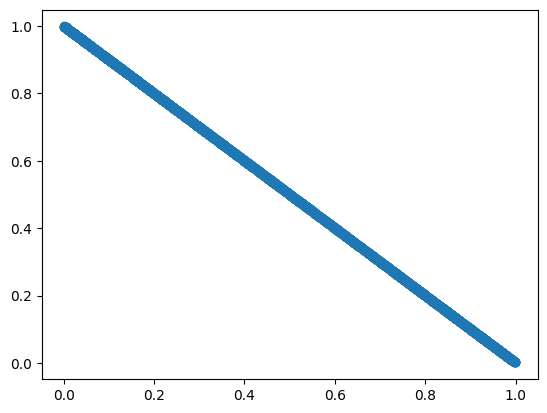

In [25]:
with torch.no_grad():
  x = []
  y = []
  for i, (data,) in enumerate(test_loader): # Unpack only one element
      data = data.to(device)
      print(data[0])
      recon_batch, mu, logvar, gauss_z, dir_z = model(data)
      x+= dir_z[:,0]
      y+= dir_z[:,1]


# Example dummy data
df = pd.DataFrame({
    'x': X[:, 0].numpy(),            # first variable
    'y': model_output.numpy(),       # or any target/prediction
    'race': race_ids.numpy()         # use as hue
})

sns.scatterplot(data=df, x='x', y='y', hue='race', palette='tab10')

  plt.scatter(x,y)
